In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import random
import sklearn
import pickle

In [2]:
np.random.seed(120)

In [3]:
users_df = pd.read_json("dane/users.jsonl", lines=True)
deliveries_df = pd.read_json("dane/deliveries.jsonl", lines=True)
products_df = pd.read_json("dane/products.jsonl", lines=True)
sessions_df = pd.read_json("dane/sessions.jsonl", lines=True)

In [4]:
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format='%Y-%m-%dT%H:%M:%S')
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S')
deliveries_df["deliver_time"] = (deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"])
deliveries_df["deliver_time"] = deliveries_df["deliver_time"] / np.timedelta64(1, 'D')
deliveries_df

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,deliver_time
0,20001,2021-05-17 02:58:18,2021-05-20 03:00:00,620,3.001181
1,20002,2021-05-22 10:25:01,2021-05-24 10:26:28,360,2.001007
2,20003,2021-01-08 23:15:05,2021-01-10 23:17:28,516,2.001655
3,20004,2021-05-21 13:23:18,2021-05-25 13:27:01,360,4.002581
4,20005,2021-02-20 12:54:25,2021-02-23 12:57:33,516,3.002176
...,...,...,...,...,...
6730,26731,2021-06-28 07:05:24,2021-06-30 07:09:05,516,2.002558
6731,26732,2021-05-28 20:47:52,2021-06-01 20:51:56,516,4.002824
6732,26733,2021-10-28 17:16:20,2021-11-02 17:20:19,360,5.002766
6733,26734,2021-09-02 07:50:58,2021-09-07 07:54:30,360,5.002454


Do deliveries_df została dodana kolumna "delivery_time", która jest wynikiem odjęcia "delivery_timestamp" od "purchase_timestamp"

In [5]:
sessions_df["month"] = sessions_df["timestamp"].apply(lambda x:"%d" % (x.month))
sessions_df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,month
0,124,2021-05-24 21:49:25,102,1001,VIEW_PRODUCT,5.0,NaN,5
1,125,2021-05-17 02:54:18,102,1233,VIEW_PRODUCT,5.0,NaN,5
2,125,2021-05-17 02:54:53,102,1234,VIEW_PRODUCT,5.0,NaN,5
3,125,2021-05-17 02:58:18,102,1234,BUY_PRODUCT,5.0,20001.0,5
4,126,2021-11-25 12:10:45,102,1283,VIEW_PRODUCT,0.0,NaN,11
...,...,...,...,...,...,...,...,...
37760,11198,2021-06-11 19:34:45,301,1317,VIEW_PRODUCT,0.0,NaN,6
37761,11198,2021-06-11 19:35:12,301,1316,VIEW_PRODUCT,0.0,NaN,6
37762,11199,2021-05-13 18:26:04,301,1036,VIEW_PRODUCT,0.0,NaN,5
37763,11199,2021-05-13 18:26:12,301,1017,VIEW_PRODUCT,0.0,NaN,5


Do sessions_df dekodując "timestamp" została dodana kolumna "month"

In [6]:
return_purchase_ids = sessions_df[sessions_df.event_type == "RETURN_PRODUCT"].purchase_id
return_purchase_ids

19       20004.0
44       20009.0
65       20013.0
69       20014.0
82       20016.0
          ...   
37638    26716.0
37654    26720.0
37678    26723.0
37742    26732.0
37759    26735.0
Name: purchase_id, Length: 1519, dtype: float64

Z sessins_df zostały wyłuskane tylko te "purchase_id", które w atrubucie "event_type" posiadają "RETURN_PRODUCT".

In [7]:
sessions_df['is_returned'] = np.where(sessions_df.purchase_id.isin(return_purchase_ids), 1, 0)
sessions_df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,month,is_returned
0,124,2021-05-24 21:49:25,102,1001,VIEW_PRODUCT,5.0,NaN,5,0
1,125,2021-05-17 02:54:18,102,1233,VIEW_PRODUCT,5.0,NaN,5,0
2,125,2021-05-17 02:54:53,102,1234,VIEW_PRODUCT,5.0,NaN,5,0
3,125,2021-05-17 02:58:18,102,1234,BUY_PRODUCT,5.0,20001.0,5,0
4,126,2021-11-25 12:10:45,102,1283,VIEW_PRODUCT,0.0,NaN,11,0
...,...,...,...,...,...,...,...,...,...
37760,11198,2021-06-11 19:34:45,301,1317,VIEW_PRODUCT,0.0,NaN,6,0
37761,11198,2021-06-11 19:35:12,301,1316,VIEW_PRODUCT,0.0,NaN,6,0
37762,11199,2021-05-13 18:26:04,301,1036,VIEW_PRODUCT,0.0,NaN,5,0
37763,11199,2021-05-13 18:26:12,301,1017,VIEW_PRODUCT,0.0,NaN,5,0


Do tabeli sessions_df została dodana kolumna "is_returned" dzięki zestawieniu dwóch tabel: sessions_df i return_purchase_ids

In [8]:
aggregation_functions = {
    'month': 'first', 
    'user_id': 'first',
    'offered_discount': 'last',
    'purchase_id': 'last',
    'event_type': 'count',
    'product_id': 'last',
    'is_returned': 'max',
}
sessions_grouped_df = sessions_df.groupby(sessions_df["session_id"]).aggregate(aggregation_functions)
sessions_grouped_df.dropna(subset=["purchase_id", "offered_discount"], inplace=True)
sessions_grouped_df

,month,user_id,offered_discount,purchase_id,event_type,product_id,is_returned
session_id,,,,,,,
125,5,102,5.0,20001.0,3,1234,0
127,5,102,0.0,20002.0,2,1001,0
128,1,102,15.0,20003.0,2,1319,0
129,5,102,0.0,20004.0,10,1293,1
131,2,102,5.0,20005.0,6,1033,0
...,...,...,...,...,...,...,...
11190,6,301,20.0,26731.0,2,1281,0
11191,5,301,10.0,26732.0,9,1084,1
11193,10,301,10.0,26733.0,4,1319,0


sessions_df zostało uporządkowane oraz zostało nazwane: sessions_grouped_df.

In [9]:
sessions_user_grouped_df = pd.merge(sessions_grouped_df, users_df, how='left')
sessions_user_grouped_df

,month,user_id,offered_discount,purchase_id,event_type,product_id,is_returned,name,city,street
0,5,102,5.0,20001.0,3,1234,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65
1,5,102,0.0,20002.0,2,1001,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65
2,1,102,15.0,20003.0,2,1319,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65
3,5,102,0.0,20004.0,10,1293,1,Klara Sałuda,Szczecin,ulica Dębowa 64/65
4,2,102,5.0,20005.0,6,1033,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65
...,...,...,...,...,...,...,...,...,...,...
6730,6,301,20.0,26731.0,2,1281,0,Olga Matus,Kraków,al. Sucharskiego 46
6731,5,301,10.0,26732.0,9,1084,1,Olga Matus,Kraków,al. Sucharskiego 46
6732,10,301,10.0,26733.0,4,1319,0,Olga Matus,Kraków,al. Sucharskiego 46
6733,9,301,5.0,26734.0,8,1075,0,Olga Matus,Kraków,al. Sucharskiego 46


Nowa tabela została zescalona z users_df.

In [10]:
sessions_user_deliver_grouped_df = pd.merge(sessions_user_grouped_df, deliveries_df, how='left')
sessions_user_deliver_grouped_df

,month,user_id,offered_discount,purchase_id,event_type,product_id,is_returned,name,city,street,purchase_timestamp,delivery_timestamp,delivery_company,deliver_time
0,5,102,5.0,20001.0,3,1234,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-05-17 02:58:18,2021-05-20 03:00:00,620,3.001181
1,5,102,0.0,20002.0,2,1001,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-05-22 10:25:01,2021-05-24 10:26:28,360,2.001007
2,1,102,15.0,20003.0,2,1319,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-01-08 23:15:05,2021-01-10 23:17:28,516,2.001655
3,5,102,0.0,20004.0,10,1293,1,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-05-21 13:23:18,2021-05-25 13:27:01,360,4.002581
4,2,102,5.0,20005.0,6,1033,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-02-20 12:54:25,2021-02-23 12:57:33,516,3.002176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6730,6,301,20.0,26731.0,2,1281,0,Olga Matus,Kraków,al. Sucharskiego 46,2021-06-28 07:05:24,2021-06-30 07:09:05,516,2.002558
6731,5,301,10.0,26732.0,9,1084,1,Olga Matus,Kraków,al. Sucharskiego 46,2021-05-28 20:47:52,2021-06-01 20:51:56,516,4.002824
6732,10,301,10.0,26733.0,4,1319,0,Olga Matus,Kraków,al. Sucharskiego 46,2021-10-28 17:16:20,2021-11-02 17:20:19,360,5.002766
6733,9,301,5.0,26734.0,8,1075,0,Olga Matus,Kraków,al. Sucharskiego 46,2021-09-02 07:50:58,2021-09-07 07:54:30,360,5.002454


Następnie została zescalona z deliveries_df.

In [11]:
all_df = pd.merge(sessions_user_deliver_grouped_df, products_df, how='left')
all_df

,month,user_id,offered_discount,purchase_id,event_type,product_id,is_returned,name,city,street,purchase_timestamp,delivery_timestamp,delivery_company,deliver_time,product_name,category_path,price
0,5,102,5.0,20001.0,3,1234,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-05-17 02:58:18,2021-05-20 03:00:00,620,3.001181,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00
1,5,102,0.0,20002.0,2,1001,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-05-22 10:25:01,2021-05-24 10:26:28,360,2.001007,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
2,1,102,15.0,20003.0,2,1319,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-01-08 23:15:05,2021-01-10 23:17:28,516,2.001655,HTC HS-S200,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,14.99
3,5,102,0.0,20004.0,10,1293,1,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-05-21 13:23:18,2021-05-25 13:27:01,360,4.002581,Hama 44292,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,44.99
4,2,102,5.0,20005.0,6,1033,0,Klara Sałuda,Szczecin,ulica Dębowa 64/65,2021-02-20 12:54:25,2021-02-23 12:57:33,516,3.002176,LCD Iiyama T1932MSC,Komputery;Monitory;Monitory LCD,3029.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6730,6,301,20.0,26731.0,2,1281,0,Olga Matus,Kraków,al. Sucharskiego 46,2021-06-28 07:05:24,2021-06-30 07:09:05,516,2.002558,Manta MM266,Sprzęt RTV;Przenośne audio i video;Odtwarzacze...,64.80
6731,5,301,10.0,26732.0,9,1084,1,Olga Matus,Kraków,al. Sucharskiego 46,2021-05-28 20:47:52,2021-06-01 20:51:56,516,4.002824,Sing It High School Musical 3 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,99.99
6732,10,301,10.0,26733.0,4,1319,0,Olga Matus,Kraków,al. Sucharskiego 46,2021-10-28 17:16:20,2021-11-02 17:20:19,360,5.002766,HTC HS-S200,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,14.99
6733,9,301,5.0,26734.0,8,1075,0,Olga Matus,Kraków,al. Sucharskiego 46,2021-09-02 07:50:58,2021-09-07 07:54:30,360,5.002454,Ricoh SG3110DN,Komputery;Drukarki i skanery;Biurowe urządzeni...,1998.14


Oraz zescalona z products_df i ostatecznie nazwana: all_df.

In [12]:
all_df.drop(["street", "purchase_timestamp", "delivery_timestamp", "purchase_id", "name", "product_name"], axis=1, inplace=True)
all_df

,month,user_id,offered_discount,event_type,product_id,is_returned,city,delivery_company,deliver_time,category_path,price
0,5,102,5.0,3,1234,0,Szczecin,620,3.001181,Sprzęt RTV;Video;Odtwarzacze DVD,193.00
1,5,102,0.0,2,1001,0,Szczecin,360,2.001007,Telefony i akcesoria;Telefony stacjonarne,58.97
2,1,102,15.0,2,1319,0,Szczecin,516,2.001655,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,14.99
3,5,102,0.0,10,1293,1,Szczecin,360,4.002581,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,44.99
4,2,102,5.0,6,1033,0,Szczecin,516,3.002176,Komputery;Monitory;Monitory LCD,3029.00
...,...,...,...,...,...,...,...,...,...,...,...
6730,6,301,20.0,2,1281,0,Kraków,516,2.002558,Sprzęt RTV;Przenośne audio i video;Odtwarzacze...,64.80
6731,5,301,10.0,9,1084,1,Kraków,516,4.002824,Gry i konsole;Gry na konsole;Gry PlayStation3,99.99
6732,10,301,10.0,4,1319,0,Kraków,360,5.002766,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,14.99
6733,9,301,5.0,8,1075,0,Kraków,360,5.002454,Komputery;Drukarki i skanery;Biurowe urządzeni...,1998.14


Z all_df zostały usunięte niepotrzebne kolumny.

In [13]:
cols = list(all_df)
cols.remove('is_returned')
cols.append('is_returned')
all_df = all_df[cols]
all_df = all_df.astype({'month': 'int32'})
all_df

,month,user_id,offered_discount,event_type,product_id,city,delivery_company,deliver_time,category_path,price,is_returned
0,5,102,5.0,3,1234,Szczecin,620,3.001181,Sprzęt RTV;Video;Odtwarzacze DVD,193.00,0
1,5,102,0.0,2,1001,Szczecin,360,2.001007,Telefony i akcesoria;Telefony stacjonarne,58.97,0
2,1,102,15.0,2,1319,Szczecin,516,2.001655,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,14.99,0
3,5,102,0.0,10,1293,Szczecin,360,4.002581,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,44.99,1
4,2,102,5.0,6,1033,Szczecin,516,3.002176,Komputery;Monitory;Monitory LCD,3029.00,0
...,...,...,...,...,...,...,...,...,...,...,...
6730,6,301,20.0,2,1281,Kraków,516,2.002558,Sprzęt RTV;Przenośne audio i video;Odtwarzacze...,64.80,0
6731,5,301,10.0,9,1084,Kraków,516,4.002824,Gry i konsole;Gry na konsole;Gry PlayStation3,99.99,1
6732,10,301,10.0,4,1319,Kraków,360,5.002766,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,14.99,0
6733,9,301,5.0,8,1075,Kraków,360,5.002454,Komputery;Drukarki i skanery;Biurowe urządzeni...,1998.14,0


Usunięcie i ponowne dodanie kolumny "is_returned" przenosi ją na koniec co pomaga w przejrzystości. Atrybuty w "month" zostały zamienione na typ 'int'.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(lowercase=False)
cities = all_df["city"].unique()
X_train_counts = count_vect.fit_transform(cities)
with open('citiec_voc.pkl', 'wb') as fid:
    pickle.dump(count_vect.vocabulary_, fid)
count_vect.vocabulary_

{'Szczecin': 4,
 'Kraków': 1,
 'Radom': 3,
 'Wrocław': 6,
 'Gdynia': 0,
 'Warszawa': 5,
 'Poznań': 2}

In [15]:
all_df["city"] = all_df.city.map(count_vect.vocabulary_)
all_df

,month,user_id,offered_discount,event_type,product_id,city,delivery_company,deliver_time,category_path,price,is_returned
0,5,102,5.0,3,1234,4,620,3.001181,Sprzęt RTV;Video;Odtwarzacze DVD,193.00,0
1,5,102,0.0,2,1001,4,360,2.001007,Telefony i akcesoria;Telefony stacjonarne,58.97,0
2,1,102,15.0,2,1319,4,516,2.001655,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,14.99,0
3,5,102,0.0,10,1293,4,360,4.002581,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,44.99,1
4,2,102,5.0,6,1033,4,516,3.002176,Komputery;Monitory;Monitory LCD,3029.00,0
...,...,...,...,...,...,...,...,...,...,...,...
6730,6,301,20.0,2,1281,1,516,2.002558,Sprzęt RTV;Przenośne audio i video;Odtwarzacze...,64.80,0
6731,5,301,10.0,9,1084,1,516,4.002824,Gry i konsole;Gry na konsole;Gry PlayStation3,99.99,1
6732,10,301,10.0,4,1319,1,360,5.002766,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,14.99,0
6733,9,301,5.0,8,1075,1,360,5.002454,Komputery;Drukarki i skanery;Biurowe urządzeni...,1998.14,0


Nazwy miast zostały zamienione na liczby przy użyciu słownika. Było to potrzebne, ponieważ zarówno model bazowy, jak i docelowy nie operuje na stringach.

In [16]:
string_attr = ["category_path"]
one_hot_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)
string_one_hot = one_hot_encoder.fit_transform(all_df[string_attr])
print(one_hot_encoder.get_feature_names_out())
string_values = pd.DataFrame(string_one_hot, columns=list(one_hot_encoder.categories_[0]))
with open('category_onehot.pkl', 'wb') as fid:
    pickle.dump(one_hot_encoder, fid)
string_values

['category_path_Gry i konsole;Gry komputerowe'
 'category_path_Gry i konsole;Gry na konsole;Gry PlayStation3'
 'category_path_Gry i konsole;Gry na konsole;Gry Xbox 360'
 'category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne'
 'category_path_Komputery;Monitory;Monitory LCD'
 'category_path_Komputery;Tablety i akcesoria;Tablety'
 'category_path_Sprzęt RTV;Audio;Słuchawki'
 'category_path_Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4'
 'category_path_Sprzęt RTV;Video;Odtwarzacze DVD'
 'category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV'
 'category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D'
 'category_path_Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące'
 'category_path_Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe'
 'category_path_Telefony i akcesoria;Telefony komórkowe'
 'category_path_Telefony i akcesoria;Telefony stacjonarne']


,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6731,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6733,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
all_df.drop(columns=string_attr,inplace=True)
all_df_copy = all_df.copy() # użyte przy uczeniu modelu bez atrybutu category_path

In [18]:
all_df = pd.concat([string_values, all_df], axis=1)
all_df

,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,...,month,user_id,offered_discount,event_type,product_id,city,delivery_company,deliver_time,price,is_returned
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5,102,5.0,3,1234,4,620,3.001181,193.00,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,102,0.0,2,1001,4,360,2.001007,58.97,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,102,15.0,2,1319,4,516,2.001655,14.99,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,5,102,0.0,10,1293,4,360,4.002581,44.99,1
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2,102,5.0,6,1033,4,516,3.002176,3029.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,6,301,20.0,2,1281,1,516,2.002558,64.80,0
6731,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,301,10.0,9,1084,1,516,4.002824,99.99,1
6732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,301,10.0,4,1319,1,360,5.002766,14.99,0
6733,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,301,5.0,8,1075,1,360,5.002454,1998.14,0


Ostatnie trzy komórki zamieniają stringi na liczby w kolumnie "category_path"

In [19]:
stdsc = preprocessing.StandardScaler()
data_scaled = stdsc.fit_transform(all_df.iloc[:,:-1].values)
with open('standard_scaler.pkl', 'wb') as fid:
    pickle.dump(stdsc, fid) 
data_scaled_df = pd.DataFrame(data_scaled, index=all_df.index, columns=all_df.columns[:-1])
data_scaled_df["is_returned"] = all_df["is_returned"]
data_scaled_df = data_scaled_df.sample(frac = 1)

Tutaj robimy skalowanie danych

In [20]:
x = data_scaled_df.iloc[:,:-1].values 
y = data_scaled_df.iloc[:, -1].values

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

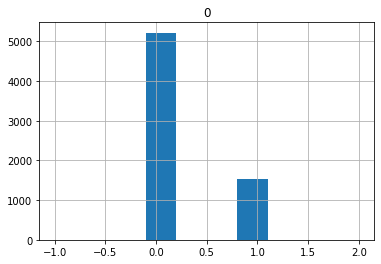

In [21]:
pd.DataFrame(y).hist(bins=10, range=(-1, 2))

Dzięki temu histogramowi widzimy dysproporcję pomiędzy niezwracanymi, a zwracanymi produktami. Aby ograniczyć wpływ tego zjawiska zastosowaniśmy undersampling. Zdecydowaliśmy się na tę czynność, ponieważ mamy dużo danych oraz różnica w reprezentacji jest wystarczająco mała.

In [22]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=99)
X_resampled, y_resampled = cc.fit_resample(x, y)

Wynik operacji undersamplingu

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

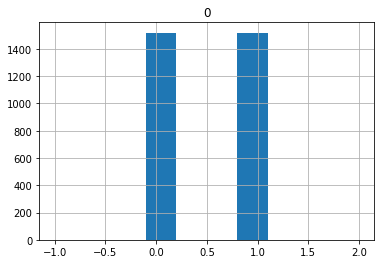

In [23]:
pd.DataFrame(y_resampled).hist(bins=10, range=(-1, 2))

Podział na zbiór treningowy i testowy

In [24]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X_resampled, y_resampled, test_size=0.2)

### Uczenie modelu i określenie jakości

In [25]:
classifier = RandomForestClassifier(
    n_estimators=150, 
    random_state=99, 
    n_jobs=100,
)
classifier.fit(x_train, y_train) 

RandomForestClassifier(n_estimators=150, n_jobs=100, random_state=99)

In [26]:
y_pred = classifier.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Accuracy: 0.8585526315789473
Precision: 0.8173652694610778
Recall: 0.9161073825503355
F1 score: 0.8639240506329113


Powyższe wyniki są zadowalające, ale sprawdzimy, czy odrzucenie któregoś z atrybutów nie pogorszy jakości modelu

In [27]:
column_names = [
    "month",
    "user_id",
    "offered_discount",
    "product_id",
    "city",
    "delivery_company",
    "deliver_time",
    "price",
]

In [28]:
models = []
for name in column_names:
    data_scaled_copy_df = data_scaled_df.copy()
    data_scaled_copy_df.drop([name], axis=1, inplace=True)
    x = data_scaled_copy_df.iloc[:,:-1].values 
    y = data_scaled_copy_df.iloc[:, -1].values
    X_resampled, y_resampled = cc.fit_resample(x, y)
    x_train_dropped, x_test_dropped, y_train_dropped, y_test_dropped = sklearn.model_selection.train_test_split(X_resampled, y_resampled, test_size=0.2)
    classifier_dropped = RandomForestClassifier(
        n_estimators=150, 
        random_state=99, 
        n_jobs=100,
    )
    classifier_dropped.fit(x_train_dropped, y_train_dropped)
    y_pred_dropped = classifier_dropped.predict(x_test_dropped)
    print('Dropped:', name)
    print('Accuracy:', accuracy_score(y_test_dropped, y_pred_dropped))
    print('Precision:', precision_score(y_test_dropped, y_pred_dropped))
    print('Recall:', recall_score(y_test_dropped, y_pred))
    print('F1 score:', f1_score(y_test_dropped, y_pred_dropped))
    models.append(classifier_dropped)

Dropped: month
Accuracy: 0.8322368421052632
Precision: 0.7830188679245284
Recall: 0.5319148936170213
F1 score: 0.8300000000000001
Dropped: user_id
Accuracy: 0.8273026315789473
Precision: 0.7883435582822086
Recall: 0.5802047781569966
F1 score: 0.8303715670436186
Dropped: offered_discount
Accuracy: 0.8273026315789473
Precision: 0.8123076923076923
Recall: 0.5454545454545454
F1 score: 0.8341232227488151
Dropped: product_id
Accuracy: 0.8618421052631579
Precision: 0.8348082595870207
Recall: 0.5466237942122186
F1 score: 0.8707692307692309
Dropped: city
Accuracy: 0.8240131578947368
Precision: 0.7768115942028986
Recall: 0.5134228187919463
F1 score: 0.833592534992224
Dropped: delivery_company
Accuracy: 0.8207236842105263
Precision: 0.7910447761194029
Recall: 0.5789473684210527
F1 score: 0.8294209702660407
Dropped: deliver_time
Accuracy: 0.8486842105263158
Precision: 0.8302469135802469
Recall: 0.5261437908496732
F1 score: 0.8539682539682539
Dropped: price
Accuracy: 0.819078947368421
Precision: 0.

In [29]:
stdsc = preprocessing.StandardScaler()
data_scaled_copy = stdsc.fit_transform(all_df_copy.iloc[:,:-1].values)
data_scaled_copy_df = pd.DataFrame(data_scaled_copy, index=all_df_copy.index, columns=all_df_copy.columns[:-1])
data_scaled_copy_df["is_returned"] = all_df_copy["is_returned"]
data_scaled_copy_df = data_scaled_copy_df.sample(frac = 1)
x = data_scaled_copy_df.iloc[:,:-1].values 
y = data_scaled_copy_df.iloc[:, -1].values
X_resampled, y_resampled = cc.fit_resample(x, y)
x_train_dropped, x_test_dropped, y_train_dropped, y_test_dropped = sklearn.model_selection.train_test_split(X_resampled, y_resampled, test_size=0.2)
classifier_dropped_category_path = RandomForestClassifier(
    n_estimators=150, 
    random_state=99, 
    n_jobs=100,
)
classifier_dropped_category_path.fit(x_train_dropped, y_train_dropped)
y_pred_dropped = classifier_dropped_category_path.predict(x_test_dropped)
print('Dropped: category_path')
print('Accuracy:', accuracy_score(y_test_dropped, y_pred_dropped))
print('Precision:', precision_score(y_test_dropped, y_pred_dropped))
print('Recall:', recall_score(y_test_dropped, y_pred_dropped))
print('F1 score:', f1_score(y_test_dropped, y_pred_dropped))
models.append(classifier_dropped_category_path)

Dropped: category_path
Accuracy: 0.8536184210526315
Precision: 0.8513931888544891
Recall: 0.870253164556962
F1 score: 0.8607198748043818


Okazuje się, że odrzucenie któregokolwiek atrybutu powoduje pogorszenie jakości modelu, dlatego zbiór atrybutów zostaje pierwotny 

### Zapisanie docelowego modelu

In [30]:
target_model = classifier
with open('target_classifier.pkl', 'wb') as fid:
    pickle.dump(target_model, fid) 

## Model Bazowy

In [31]:
basic_model = sklearn.svm.LinearSVC()
basic_model.fit(x_train, y_train)
y_pred_basic = basic_model.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred_basic))
print('Precision:', precision_score(y_test, y_pred_basic))
print('Recall:', recall_score(y_test, y_pred_basic))
print('F1 score:', f1_score(y_test, y_pred_basic))

Accuracy: 0.5608552631578947
Precision: 0.5459940652818991
Recall: 0.6174496644295302
F1 score: 0.5795275590551181


d:\nauka\sem5\ssne\cwiczenia\.venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [32]:
with open('basic_classifier.pkl', 'wb') as fid:
    pickle.dump(basic_model, fid) 